In [2]:
from pathlib import Path
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy as scy
#from scipy.signal import gaussian
from scipy.optimize import leastsq
from scipy.stats import norm
from pylab import rcParams
import textwrap
import itertools

In [3]:
# LabOne Q:
from laboneq.simple import *

# plotting and fitting functionality
from laboneq.analysis.fitting import (
    lorentzian,
    oscillatory,
    oscillatory_decay,
)
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

# descriptor imports
from laboneq.contrib.example_helpers.descriptors.shfsg_shfqa_pqsc import (
    descriptor_shfsg_shfqa_pqsc,
)

from laboneq.contrib.example_helpers.descriptors.shfsg_shfqa_shfqc_hdawg_pqsc import (
    descriptor_shfsg_shfqa_shfqc_hdawg_pqsc,
)

from laboneq.contrib.example_helpers.randomized_benchmarking_helper import (
    make_pauli_gate_map,
    clifford_parametrized,
    generate_play_rb_pulses,
)

from laboneq.contrib.example_helpers.feedback_helper import (
    state_emulation_pulse,
    create_calibration_experiment,
    create_discrimination_experiment,
)

from laboneq.contrib.example_helpers.generate_example_datastore import (
    generate_example_datastore,
    get_first_named_entry,
)

from zhinst.utils.shfqa.multistate import QuditSettings
from laboneq.analysis import calculate_integration_kernels
# for saving results and pulse sheets

In [4]:
descriptor = """\
instruments:
  SHFQC:
  - address: DEV12158
    uid: device_shfqc
    interface: 1gbe

connections:
  device_shfqc:
    - iq_signal: q0/drive_line
      ports: SGCHANNELS/0/OUTPUT
    - iq_signal: q0/drive_line_ef
      ports: SGCHANNELS/0/OUTPUT
    - iq_signal: q1/drive_line
      ports: SGCHANNELS/1/OUTPUT
    - iq_signal: q1/drive_line_ef
      ports: SGCHANNELS/1/OUTPUT
    - iq_signal: q2/drive_line
      ports: SGCHANNELS/2/OUTPUT
    - iq_signal: q2/drive_line_ef
      ports: SGCHANNELS/2/OUTPUT
    - iq_signal: q3/drive_line
      ports: SGCHANNELS/3/OUTPUT
    - iq_signal: q3/drive_line_ef
      ports: SGCHANNELS/3/OUTPUT
    - iq_signal: q4/drive_line
      ports: SGCHANNELS/4/OUTPUT
    - iq_signal: q4/drive_line_ef
      ports: SGCHANNELS/4/OUTPUT
    - iq_signal: q5/drive_line
      ports: SGCHANNELS/5/OUTPUT
    - iq_signal: q5/drive_line_ef
      ports: SGCHANNELS/5/OUTPUT
    - iq_signal: q0/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q0/acquire_line
      ports: [QACHANNELS/0/INPUT]
    - iq_signal: q1/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q1/acquire_line
      ports: [QACHANNELS/0/INPUT]
    - iq_signal: q2/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q2/acquire_line
      ports: [QACHANNELS/0/INPUT]
    - iq_signal: q3/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q3/acquire_line
      ports: [QACHANNELS/0/INPUT]
    - iq_signal: q4/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q4/acquire_line
      ports: [QACHANNELS/0/INPUT]
    - iq_signal: q5/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q5/acquire_line
      ports: [QACHANNELS/0/INPUT]
"""

# Define and Load our Device Setup
device_setup = DeviceSetup.from_descriptor(
    yaml_text=descriptor, #descriptor_shfsg_shfqa_shfqc_hdawg_pqsc,
    server_host="localhost",  # ip address of the LabOne dataserver used to communicate with the instruments
    server_port="8004",  # port number of the dataserver - default is 8004
    setup_name="my_setup",  # setup name
)

def lsg(qubit_str, line_str):
    return device_setup.logical_signal_groups[qubit_str].logical_signals[line_str]

lsg_keys = device_setup.logical_signal_groups.keys()

# perform experiments in emulation mode only? - if True, also generate dummy data for fitting
emulate = True

# create and connect to a session
session = Session(device_setup=device_setup)
session.connect(do_emulation=emulate)

[2024.06.04 14:44:12.066] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /Users/james/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/honourable_code/quench/june/laboneq_output/log
[2024.06.04 14:44:12.068] INFO    VERSION: laboneq 2.29.0
[2024.06.04 14:44:12.071] INFO    Connecting to data server at localhost:8004
[2024.06.04 14:44:12.072] INFO    Connected to Zurich Instruments LabOne Data Server version 24.01 at localhost:8004
[2024.06.04 14:44:12.074] WARNING SHFQC/QA:dev12158: Include the device options 'SHFQC/QC6CH' in the device setup ('options' field of the 'instruments' list in the device setup descriptor). This will become a strict requirement in the future.
[2024.06.04 14:44:12.078] INFO    Configuring the device setup
[2024.06.04 14:44:12.079] INFO    The device setup is configured


In [5]:
def plot_sweeper(f, result, unwrap = True, deg = True):
    """Plot results from Sweeper"""
    f = f/1e9
    power = 10*np.log10(np.abs(result)**2/50*1000)
    phase = np.unwrap(np.angle(result, deg = deg)) if unwrap is True else np.angle(result, deg = deg)
    phase_unit = 'deg' if deg is True else 'rad'
    
    fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)
    ax0.plot(f, power, '.-', color = 'steelblue', label = 'power')
    ax0.legend(loc='upper left')
    ax0.set_ylabel('Power (dBm)')
    ax1.plot(f, phase, '.-', color = 'orange', label = 'phase')
    ax1.legend(loc='upper left')
    ax1.set_xlabel('Frequency (GHz)')
    fig.align_ylabels([ax0, ax1])
    ax0.grid()
    ax1.grid()
    ax1.set_ylabel(f'Phase ({phase_unit})')
    plt.tight_layout()
    plt.show()

def plot_n(x, y, z, do_plot = 1):
    """Plot multiple results"""
    if do_plot == 1: 
        power = 10*np.log10(np.abs(z)**2/50*1000)
        phase = np.angle(z, deg = True)

        fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
        for i in range(len(power)):
            ax0.plot(x/1e9, power[i], '.-', color = colors[i], label = f'gain = {y[i]}')
            ax1.plot(x/1e9, phase[i], '.-', color = colors[i], label = f'gain = {y[i]}')
        ax0.set_ylabel('Power (dBm)')
        ax1.set_ylabel('Phase (deg)')
        ax1.set_xlabel('Frequency (GHz)')
        ax0.legend(loc='upper left')
        ax1.legend(loc='upper left')
        ax0.grid()
        ax1.grid()
        fig.tight_layout()
        fig.align_ylabels([ax0, ax1])

def plot_2d(x, y, z, do_plot = 1):
    """2D plot"""
    if do_plot == 1:   
        x = x/1e9
        x0 = np.zeros(len(x)+1)    
        x0[:-1] = x - (x[1]-x[0])/2
        x0[-1]= x[-1] + (x[1]-x[0])/2    
        y0 = np.zeros(len(y)+1)
        y0[:-1] = y - (y[1]-y[0])/2
        y0[-1]= y[-1] + (y[1]-y[0])/2

        z_abs = 10*np.log10(np.abs(z)**2/50*1000)
        z_angle = np.angle(z, deg = True)
        X, Y = np.meshgrid(x0 ,y0)

        fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)
        c0 = ax0.pcolormesh(X, Y,z_abs)
        ax0.set_yticks(y)
        ax0.set_ylabel('Gain')
        ax0.set_title('Power (dBm)')
        fig.colorbar(c0, ax=ax0)

        c1 = ax1.pcolormesh(X, Y, z_angle)
        ax1.set_yticks(y)
        ax1.set_xlabel('Offset frequency (GHz)')
        ax1.set_ylabel('Gain')
        ax1.set_title('Phase (degree)')
        fig.colorbar(c1, ax=ax1)

        fig.tight_layout()
        plt.show() 


In [6]:
num_qudits = len(lsg_keys)

ro_pulse_duration = 1e-6

qudits_params = {
"qudits":lsg_keys,
"ro_num_states": num_qudits * [2],
"ro_cent_f": 0,
"ro_df":     num_qudits * [10e6],
"ro_pin_range":   0,
"ro_pout_range":  0,
"ro_pulse_data": {},
"ro_pulse_delay": 0,
"ro_int_t": ro_pulse_duration,
"ro_int_delay": 0e-9,

"ro_int_weights": {},
"thresholds":{},
"ro_snr": num_qudits * [0],
"ro_fidelity": num_qudits * [0],
"ro_fidelity_ef": num_qudits * [0],
"ro_x_talk_matrix": {},
"wait_after_int": 5e-6,

"dr_cent_f": num_qudits * [7e9], # <= 3 different LO f, because ch1 and ch2 share the same LO, and same for ch3 and ch4, ch5 and ch6
"dr_df": num_qudits * [10e6],
"dr_df_ef": num_qudits * [10e6],
"dr_p_range":   num_qudits * [0],
"dr_pulse_data": num_qudits * [0.5],
"dr_pulse_data_ef": num_qudits * [0.5],
"dr_pi_pulse": {},
"dr_pi_pulse_ef": {},
"dr_pi/2_pulse": {},
"dr_pi/2_pulse_ef": {},
"T1": num_qudits * [0],
"T2": num_qudits * [0],
"T2_echo": num_qudits * [0],
"T2_Ramsey": num_qudits * [0],
"T2_CPMG": num_qudits * [0],
"T1_ef": num_qudits * [0],
"T2_echo_ef": num_qudits * [0],
"T2_Ramsey_ef": num_qudits * [0],
"T2_CPMG_ef": num_qudits * [0],
"1q_gate_fidelity": num_qudits * [0],
"2q_gate_fidelity": num_qudits * [0],
"dr_x_talk_matrix": {},
}

states_str = ["g", "e", "f", "h"]

In [7]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter
ro_port_mode = PortMode.LF if qudits_params["ro_cent_f"] == 0 else PortMode.RF
# def res_spectroscopy_CW(freq_sweep, exp_settings):
#     # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
#     exp_spec = Experiment(
#         uid=exp_settings["exp_name"],
#         signals=[
#             ExperimentSignal(("measure"), map_to=lsg("q0", "measure_line")),
#             ExperimentSignal(("acquire"), map_to=lsg("q0", "acquire_line")),
#         ],
#     )

#     ## define experimental sequence
#     # loop - average multiple measurements for each frequency - measurement in spectroscopy mode
#     with exp_spec.acquire_loop_rt(
#         uid="shots",
#         count=exp_settings["num_averages"],
#         acquisition_type=AcquisitionType.SPECTROSCOPY,
#     ):
#         with exp_spec.sweep(uid="res_freq", parameter=freq_sweep):
#             # readout pulse and data acquisition
#             with exp_spec.section(uid="spectroscopy"):
#                 # resonator signal readout
#                 exp_spec.acquire(
#                     signal="acquire",
#                     handle="res_spec",
#                     length=exp_settings["integration_time"],
#                 )
#             # relax time after readout - for qubit relaxation to groundstate and signal processing
#             with exp_spec.section(uid="relax", length=1e-6):
#                 exp_spec.reserve(signal="measure")

#     return exp_spec

# def exp_signal(exp_params, num_states=2):
#     threshold = 0
#     if "ef" in exp_params["exp_name"] or num_states >2:
#         signals = [signal for signal_list in [
#             [ExperimentSignal(("drive_" + qubit),   map_to=lsg(qubit, "drive_line")),
#              ExperimentSignal(("drive_ef_" + qubit),map_to=lsg(qubit, "drive_line_ef")),
#              ExperimentSignal(("measure_" + qubit), map_to=lsg(qubit, "measure_line")),
#              ExperimentSignal(("acquire_" + qubit), map_to=lsg(qubit, "acquire_line")),  
#             ] for qubit in exp_params["qubits"]
#             ] for signal in signal_list
#         ]
#     else:
#         signals = [signal for signal_list in [
#                 [   ExperimentSignal(("drive_" + qubit),   map_to=lsg(qubit, "drive_line")),                    
#                     ExperimentSignal(("measure_" + qubit), map_to=lsg(qubit, "measure_line")),
#                     ExperimentSignal(("acquire_" + qubit), map_to=lsg(qubit, "acquire_line")),  
#                 ] for qubit in exp_params["qubits"]
#             ] for signal in signal_list
#         ]  
    
#     exp_signal = Experiment(uid=exp_params["exp_name"], signals= signals)
#     return exp_signal

def compile_run(session, exp_params, exp):
    compiler_settings = None
    if "rb" in exp_params["exp_name"]:
        compiler_settings = {"SHFSG_MIN_PLAYWAVE_HINT": 256}

    compiled_exp = session.compile(exp, compiler_settings = compiler_settings)
    results = session.run(compiled_exp)    
    Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
    show_pulse_sheet(f'''Pulse_Sheets/{exp_params["exp_name"]}''', compiled_exp, interactive=exp_params["interactive"])
    if exp_params["plot_simulation"] == 1:
        plot_simulation(compiled_exp, start_time=exp_params["plt_start_time"], length=exp_params["plt_length"])
    return results

def define_calibration(qudits_params):
    # the calibration object will later be applied to the device setup
    calibration = Calibration()

    for qn in qudits_params["qudits"]:
        calibration[lsg(qn, "acquire_line")] = SignalCalibration(
            local_oscillator = Oscillator(frequency = qudits_params["ro_cent_f"]),
            oscillator =       Oscillator(frequency = qudits_params["ro_df"][int(qn[1])],
                                    modulation_type = ModulationType.SOFTWARE),
            # add an offset between the readout pulse and the start of the data acquisition - to compensate for round-trip time of readout pulse
            port_delay = qudits_params["ro_pulse_delay"] + qudits_params["ro_int_delay"],
            range = qudits_params["ro_pin_range"],
            port_mode = ro_port_mode,
        )
        # measure line
        calibration[lsg(qn, "measure_line")] = SignalCalibration(
            local_oscillator = Oscillator(frequency = qudits_params["ro_cent_f"]),
            oscillator =       Oscillator(frequency = qudits_params["ro_df"][int(qn[1])],
                                modulation_type = ModulationType.SOFTWARE),
            port_delay = qudits_params["ro_pulse_delay"] ,
            range = qudits_params["ro_pout_range"],
            port_mode = ro_port_mode
        )
        calibration[lsg(qn, "drive_line")] = SignalCalibration(
            # verify which qubits share the same LOs!
            local_oscillator = Oscillator(frequency = qudits_params["dr_cent_f"][int(qn[1])]),
            # each logical signal can have an oscillator associated with it
            oscillator =       Oscillator(frequency = qudits_params["dr_df"][int(qn[1])],
                                modulation_type = ModulationType.HARDWARE),
            range = qudits_params["dr_p_range"][int(qn[1])],
        )
        calibration[lsg(qn, "drive_line_ef")] = SignalCalibration(
        # verify which qubits share the same LOs!
        local_oscillator = Oscillator(frequency = qudits_params["dr_cent_f"][int(qn[1])]),
        # each logical signal can have an oscillator associated with it
        oscillator =       Oscillator(frequency = qudits_params["dr_df_ef"][int(qn[1])],
                            modulation_type = ModulationType.HARDWARE),
        range = qudits_params["dr_p_range"][int(qn[1])],
        )
    return calibration

def res_spectroscopy(session, exp_params):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp = Experiment(
        uid=exp_params["exp_name"],
        signals=[
            ExperimentSignal(("measure"), map_to=lsg("q0", "measure_line")),
            ExperimentSignal(("acquire"), map_to=lsg("q0", "acquire_line")),
        ],
    )
    ## define experimental sequence
    # loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    amplitude_sweep = exp_params["ro_osc_gain"]
    if "amp_sweep" in exp_params.keys():
        amplitude_sweep = exp_params["amp_sweep"]

    exec_str = """
    with exp.acquire_loop_rt(
    uid=exp_params["exp_name"] + "_shots",
    count=2**exp_params["num_averages"],
    acquisition_type=AcquisitionType.SPECTROSCOPY,
    averaging_mode= exp_params["average_mode"],
    ):
    with exp.sweep(uid=exp_params["exp_name"], parameter=exp_params["freq_sweep"]):
        # readout pulse and data acquisition
        with exp.section(uid="spectroscopy"):
            # resonator signal readout
            if "pulse" in exp_params["exp_name"]: 
                exp.play(signal="measure", pulse=exp_params['readout_pulse'])
            exp.acquire(
                signal="acquire",
                handle=exp_params["exp_name"],
                length=exp_params["integration_time"],
            )
        # relax time after readout - for qubit relaxation to groundstate and signal processing
        with exp.section(uid="relax", length=exp_params["wait_after_int"]):
            exp.reserve(signal="measure")
            exp.reserve(signal="acquire")
        """
    if "2D" in exp_params["exp_name"]:
        with exp.sweep(uid="res_amp", parameter=exp_params["amp_sweep"]):
            exec(exec_str)    
    else:
        with exp.acquire_loop_rt(
            uid=exp_params["exp_name"] + "_shots",
            count=2**exp_params["num_averages"],
            acquisition_type=AcquisitionType.SPECTROSCOPY,
            averaging_mode= exp_params["average_mode"],
        ):
            with exp.sweep(uid=exp_params["exp_name"], parameter=exp_params["freq_sweep"]):
                # readout pulse and data acquisition
                with exp.section(uid="spectroscopy"):
                    # resonator signal readout
                    if "pulse" in exp_params["exp_name"]: 
                        exp.play(signal="measure", pulse=exp_params['readout_pulse'])
                    exp.acquire(
                        signal="acquire",
                        handle=exp_params["exp_name"],
                        length=exp_params["integration_time"],
                    )
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                with exp.section(uid="relax", length=exp_params["wait_after_int"]):
                    exp.reserve(signal="measure")
                    exp.reserve(signal="acquire")
                    
    cal = Calibration()
    # sets the oscillator of the experimental measure signal
    cal["measure"] = SignalCalibration(
        local_oscillator = Oscillator(frequency = exp_params["ro_cent_f"]),
        oscillator=Oscillator(frequency=exp_params["freq_sweep"], modulation_type=ModulationType.HARDWARE),
        amplitude=amplitude_sweep,
        range = exp_params["ro_pout_range"]
    )
    cal["acquire"] = SignalCalibration(
        local_oscillator = Oscillator("ro_cent_f_acquire", frequency = exp_params["ro_cent_f"]),
        range = exp_params["ro_pin_range"]
    )
    exp.set_calibration(cal)

    results = compile_run(session, exp_params, exp)

    return results

def propagation_delay(session, exp_params, qudits_params):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp = Experiment(
        uid=exp_params["exp_name"],
        signals=[
            ExperimentSignal(("measure"), map_to=lsg("q0", "measure_line")),
            ExperimentSignal(("acquire"), map_to=lsg("q0", "acquire_line")),
        ],
    )

    ## define experimental sequence
    # outer loop - vary drive frequency
    with exp.sweep(uid=exp_params["exp_name"], parameter=exp_params["delay_sweep"]):
        with exp.acquire_loop_rt(
            uid=exp_params["exp_name"] + "_shots",
            count=2**exp_params["delay_num_averages"],
            acquisition_type=AcquisitionType.INTEGRATION,
        ):
            # readout pulse and data acquisition
            with exp.section(uid="readout"):
                # play resonator excitation pulse
                exp.play(signal="measure", pulse=qudits_params["ro_pulse_data"]["q0"])
                # resonator signal readout
                exp.acquire(
                    signal="acquire", handle=exp_params["exp_name"], kernel= qudits_params["ro_pulse_data"]["q0"]
                )
            with exp.section(uid="relax"):
                exp.delay(signal="measure", time=qudits_params["wait_after_int"])
                
    cal = Calibration()
    cal["acquire"] = SignalCalibration(port_delay=exp_params["delay_sweep"])
    exp.set_calibration(cal)

    results = compile_run(session, exp_params, exp)
    return results

In [8]:
# parameters for all resonator spectroscopy experiment (cw, pulse and 2d)
start_freq = 350.0e6
stop_freq = 450.0e6
num_points = 201
num_averages = 10
average_mode = AveragingMode.CYCLIC # AveragingMode.SEQUENTIAL #

ro_cent_f = 1e9
ro_pin_range = -5
ro_pout_range = -30


integration_time = 2e-6
wait_after_int = integration_time + 5e-6
freq_sweep = LinearSweepParameter(uid = f"res_freq_q0", start = start_freq, stop = stop_freq, count = num_points, axis_name="Frequency [Hz]")

# define the experiment with the frequency sweep relevant for qubit 0
exp_params_res = {
    "ro_cent_f": ro_cent_f,
    "ro_pout_range": ro_pout_range,
    "ro_pin_range": ro_pin_range,
    "freq_sweep": freq_sweep,
    "num_averages": num_averages,
    "integration_time": integration_time,
    "wait_after_int": wait_after_int,
    "average_mode": average_mode,
    "plot_simulation": 1,
    "plt_start_time": 0,
    "plt_length":10e-6,
    "interactive": False,
    }

# parameters if output waveforms is pulse
envelop_duration = 2e-6
envelop_amplitude = 1
envelop_width = envelop_duration
envelop_waveform  = pulse_library.gaussian_square(uid = "readout_envelop_q0", length = envelop_duration, amplitude = envelop_amplitude, width = envelop_width, sigma = 0.2)

[2024.06.04 14:44:46.838] INFO    Starting LabOne Q Compiler run...
[2024.06.04 14:44:47.135] INFO    Schedule completed. [0.291 s]
[2024.06.04 14:44:47.217] INFO    Code generation completed for all AWGs. [0.081 s]
[2024.06.04 14:44:47.219] INFO    Completed compilation step 1 of 1. [0.375 s]
[2024.06.04 14:44:47.228] INFO     ────────────────────────────────────────────────────────────────── 
[2024.06.04 14:44:47.230] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.06.04 14:44:47.231] INFO     ────────────────────────────────────────────────────────────────── 
[2024.06.04 14:44:47.232] INFO      device_shfqc     0         21            0           0         0  
[2024.06.04 14:44:47.233] INFO     ────────────────────────────────────────────────────────────────── 
[2024.06.04 14:44:47.236] INFO      TOTAL                      21            0                     0  
[2024.06.04 14:44:47.238] INFO     ────────────────────────────────────────────────────

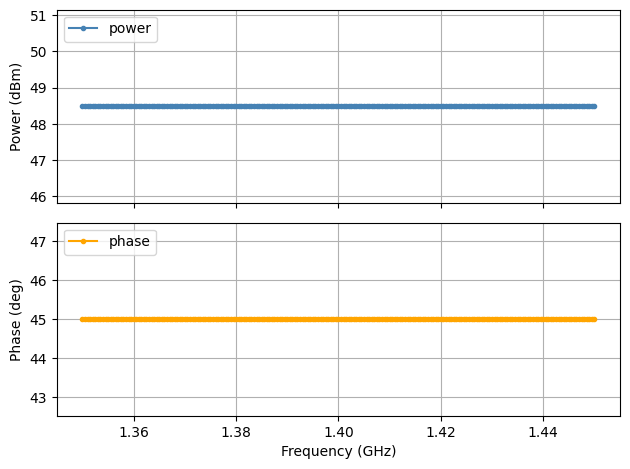

In [9]:
exp_params_cw_res_spec = exp_params_res
exp_params_cw_res_spec.update({
    "exp_name": "cw",
    "wait_after_int": wait_after_int,
    "ro_osc_gain": 0.5,
    "plot_simulation": 0,
})

results_cw_res = res_spectroscopy(session, exp_params_cw_res_spec)

f = np.transpose(np.array(results_cw_res.acquired_results[exp_params_cw_res_spec["exp_name"]].axis))
data  = results_cw_res.acquired_results[exp_params_cw_res_spec["exp_name"]].data
plot_sweeper(f + exp_params_cw_res_spec["ro_cent_f"], data)

### SET spectroscopy

In [10]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter

ro_port_mode = PortMode.LF if qudits_params["ro_cent_f"] == 0 else PortMode.RF
print(ro_port_mode)
def define_calibration(qudits_params):
    # the calibration object will later be applied to the device setup
    calibration = Calibration()

    for qn in qudits_params["qudits"]:
        calibration[lsg(qn, "acquire_line")] = SignalCalibration(
            local_oscillator = Oscillator(frequency = qudits_params["ro_cent_f"]),
            oscillator =       Oscillator(frequency = qudits_params["ro_df"][int(qn[1])],
                                    modulation_type = ModulationType.SOFTWARE),
            # add an offset between the readout pulse and the start of the data acquisition - to compensate for round-trip time of readout pulse
            port_delay = qudits_params["ro_pulse_delay"] + qudits_params["ro_int_delay"],
            range = qudits_params["ro_pin_range"],
            port_mode=ro_port_mode,

        )
        # measure line
        calibration[lsg(qn, "measure_line")] = SignalCalibration(
            local_oscillator = Oscillator(frequency = qudits_params["ro_cent_f"]),
            oscillator =       Oscillator(frequency = qudits_params["ro_df"][int(qn[1])],
                                modulation_type = ModulationType.SOFTWARE),
            port_delay = qudits_params["ro_pulse_delay"] ,
            range = qudits_params["ro_pout_range"],
            port_mode=ro_port_mode,
        )
        calibration[lsg(qn, "drive_line")] = SignalCalibration(
            # verify which qubits share the same LOs!
            local_oscillator = Oscillator(frequency = qudits_params["dr_cent_f"][int(qn[1])]),
            # each logical signal can have an oscillator associated with it
            oscillator =       Oscillator(frequency = qudits_params["dr_df"][int(qn[1])],
                                modulation_type = ModulationType.HARDWARE),
            range = 5,
        )
        calibration[lsg(qn, "drive_line_ef")] = SignalCalibration(
        # verify which qubits share the same LOs!
        local_oscillator = Oscillator(frequency = qudits_params["dr_cent_f"][int(qn[1])]),
        # each logical signal can have an oscillator associated with it
        oscillator =       Oscillator(frequency = qudits_params["dr_df_ef"][int(qn[1])],
                            modulation_type = ModulationType.HARDWARE),
        range = qudits_params["dr_p_range"][int(qn[1])],
        )
    return calibration

calibration = define_calibration(qudits_params)
device_setup.set_calibration(calibration)
g1_len = 1000e-6
g2_len = 20e-6 # this pulse length and g1_len determines how many steps of sweeping g2 pulse, i.e. g1_len/g2_len

g1_pulse = pulse_library.const(uid = "g1_pulse", amplitude = 0.3, length = g1_len, can_compress=True)
g2_pulse = pulse_library.const(uid = "g2_pulse", amplitude = 0.3, length = g2_len, can_compress=True)

amp_sweep_g1 = LinearSweepParameter("amp_g1", start=-0.0, stop = 1.0, count=401)

def charge_stability_diagram():
    exp = Experiment(uid="exp", 
        signals = [
                ExperimentSignal(("drive_g1"),   map_to=lsg("q0", "drive_line")), 
                ExperimentSignal(("drive_g2"),   map_to=lsg("q1", "drive_line")),                   
                ExperimentSignal(("measure_g"), map_to=lsg("q0", "measure_line")),
                ExperimentSignal(("acquire_g"), map_to=lsg("q0", "acquire_line")),  
        ]  
    )
    with exp.acquire_loop_rt(
        uid="exp",
        count=2**1,
        acquisition_type = AcquisitionType.SPECTROSCOPY,
        averaging_mode = AveragingMode.CYCLIC,
    ):
        with exp.sweep(uid='sweep amp g1', parameter=amp_sweep_g1):
            with exp.section(uid="g1_sweep", alignment = SectionAlignment.RIGHT):
                with exp.section(uid = "g1_1"):
                    exp.play(signal = "drive_g1", pulse=g1_pulse, amplitude = amp_sweep_g1, phase = 180) # note that the phase does not affect the output amplitude 
#                 for i in range(int(g1_len/g2_len)):
#                     if i == 0:
#                         str_g2 = None
#                     else:
#                         str_g2 = f"g2_sweep_{i-1}"

#                     with exp.section(uid= f"g2_sweep_{i}", alignment=SectionAlignment.RIGHT, play_after = str_g2):
#                         exp.play(signal = "drive_g2", pulse=g2_pulse, amplitude = 0.1+0.1*i, phase=180)
                with exp.section(uid=f"readout"):
                #     exp.acquire(
                #         signal="acquire_g",
                #         handle="results",
                #         length=50e-6,
                #     )
                # with exp.section(uid=f"relax", length=2e-6, play_after= f"readout"):
                #     # exp.reserve(signal="measure")
                #     exp.reserve(signal="acquire_g")
                    exp.measure(acquire_signal ="acquire_g",
                    handle = "results", 
                    integration_length=50e-6,
                    reset_delay=1e-6)
# 
    cal = Calibration()
  
    cal["drive_g1"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=0),
        oscillator=Oscillator(frequency=0),
        port_mode=PortMode.LF,
        range=5)
#     cal["drive_g2"] = SignalCalibration(
#         local_oscillator=Oscillator(frequency=0),
#         port_mode=PortMode.LF,
#         oscillator=Oscillator(frequency=0),
#         range=0)
    cal["acquire_g"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=0),
        port_mode=PortMode.LF,
        oscillator=Oscillator(frequency=395.0e6),
        # port_delay = 100e-6,
        range=0)
    exp.set_calibration(cal)

               
    compiler_settings = None
    compiled_exp = session.compile(exp, compiler_settings = compiler_settings)
    results = session.run(compiled_exp)    
    Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
    show_pulse_sheet(f'''Pulse_Sheets/csd''', compiled_exp) 

    return results

results = charge_stability_diagram()

data = results.acquired_results["results"].data

PortMode.LF
[2024.06.04 14:45:06.299] INFO    Resolved modulation type of oscillator 'osc_53' on signal 'acquire_g' to HARDWARE
[2024.06.04 14:45:06.300] INFO    Resolved modulation type of oscillator 'osc_51' on signal 'drive_g1' to HARDWARE
[2024.06.04 14:45:06.301] INFO    Starting LabOne Q Compiler run...
[2024.06.04 14:45:06.412] INFO    Schedule completed. [0.108 s]
[2024.06.04 14:46:05.614] INFO    Code generation completed for all AWGs. [59.202 s]
[2024.06.04 14:46:05.616] INFO    Completed compilation step 1 of 1. [59.313 s]
[2024.06.04 14:46:05.623] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.06.04 14:46:05.625] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.06.04 14:46:05.626] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.06.04 14:46:05.627] INFO      device_shfqc        0         14            0           0         0  
[2024.06.04 14:46:05.629] INFO      

In [11]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter

ro_port_mode = PortMode.LF if qudits_params["ro_cent_f"] == 0 else PortMode.RF
print(ro_port_mode)
def define_calibration(qudits_params):
    # the calibration object will later be applied to the device setup
    calibration = Calibration()

    for qn in qudits_params["qudits"]:
        calibration[lsg(qn, "acquire_line")] = SignalCalibration(
            local_oscillator = Oscillator(frequency = qudits_params["ro_cent_f"]),
            oscillator =       Oscillator(frequency = qudits_params["ro_df"][int(qn[1])],
                                    modulation_type = ModulationType.SOFTWARE),
            # add an offset between the readout pulse and the start of the data acquisition - to compensate for round-trip time of readout pulse
            port_delay = qudits_params["ro_pulse_delay"] + qudits_params["ro_int_delay"],
            range = qudits_params["ro_pin_range"],
            port_mode=ro_port_mode,

        )
        # measure line
        calibration[lsg(qn, "measure_line")] = SignalCalibration(
            local_oscillator = Oscillator(frequency = qudits_params["ro_cent_f"]),
            oscillator =       Oscillator(frequency = qudits_params["ro_df"][int(qn[1])],
                                modulation_type = ModulationType.SOFTWARE),
            port_delay = qudits_params["ro_pulse_delay"] ,
            range = qudits_params["ro_pout_range"],
            port_mode=ro_port_mode,
        )
        calibration[lsg(qn, "drive_line")] = SignalCalibration(
            # verify which qubits share the same LOs!
            local_oscillator = Oscillator(frequency = qudits_params["dr_cent_f"][int(qn[1])]),
            # each logical signal can have an oscillator associated with it
            oscillator =       Oscillator(frequency = qudits_params["dr_df"][int(qn[1])],
                                modulation_type = ModulationType.HARDWARE),
            range = 5,
        )
        calibration[lsg(qn, "drive_line_ef")] = SignalCalibration(
        # verify which qubits share the same LOs!
        local_oscillator = Oscillator(frequency = qudits_params["dr_cent_f"][int(qn[1])]),
        # each logical signal can have an oscillator associated with it
        oscillator =       Oscillator(frequency = qudits_params["dr_df_ef"][int(qn[1])],
                            modulation_type = ModulationType.HARDWARE),
        range = qudits_params["dr_p_range"][int(qn[1])],
        )
    return calibration

calibration = define_calibration(qudits_params)
device_setup.set_calibration(calibration)
g1_len = 100e-6
g2_len = 20e-6 # this pulse length and g1_len determines how many steps of sweeping g2 pulse, i.e. g1_len/g2_len

g1_pulse = pulse_library.const(uid = "g1_pulse", amplitude = 0.3, length = g1_len, can_compress=True)
g2_pulse = pulse_library.const(uid = "g2_pulse", amplitude = 0.3, length = g2_len, can_compress=True)

amp_sweep_g1 = LinearSweepParameter("amp_g1", start=-0.0, stop = 1.0, count=401)

def charge_stability_diagram():
    exp = Experiment(uid="exp", 
        signals = [
                ExperimentSignal(("drive_g1"),   map_to=lsg("q0", "drive_line")), 
#                 ExperimentSignal(("drive_g2"),   map_to=lsg("q1", "drive_line")),                   
                ExperimentSignal(("measure_g"), map_to=lsg("q0", "measure_line")),
                ExperimentSignal(("acquire_g"), map_to=lsg("q0", "acquire_line")),  
        ]  
    )
    with exp.acquire_loop_rt(
        uid="exp",
        count=2**3,
        acquisition_type = AcquisitionType.SPECTROSCOPY,
        averaging_mode = AveragingMode.CYCLIC,
    ):
        with exp.sweep(uid='sweep amp g1', parameter=amp_sweep_g1):
            with exp.section(uid="g1_sweep", alignment = SectionAlignment.RIGHT):
                with exp.section(uid = "g1_1"):
                    exp.play(signal = "drive_g1", pulse=g1_pulse, amplitude = amp_sweep_g1, phase = 180) # note that the phase does not affect the output amplitude 
#                 for i in range(int(g1_len/g2_len)):
#                     if i == 0:
#                         str_g2 = None
#                     else:
#                         str_g2 = f"g2_sweep_{i-1}"

#                     with exp.section(uid= f"g2_sweep_{i}", alignment=SectionAlignment.RIGHT, play_after = str_g2):
#                         exp.play(signal = "drive_g2", pulse=g2_pulse, amplitude = 0.1+0.1*i, phase=180)
                with exp.section(uid=f"readout"):
                #     exp.acquire(
                #         signal="acquire_g",
                #         handle="results",
                #         length=50e-6,
                #     )
                # with exp.section(uid=f"relax", length=2e-6, play_after= f"readout"):
                #     # exp.reserve(signal="measure")
                #     exp.reserve(signal="acquire_g")
                    exp.measure(acquire_signal ="acquire_g",
                    handle = "results", 
                    integration_length=50e-6,
                    reset_delay=1000e-6)
# 
    cal = Calibration()
  
    cal["drive_g1"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=0),
        oscillator=Oscillator(frequency=0),
        port_mode=PortMode.LF,
        range=5)
#     cal["drive_g2"] = SignalCalibration(
#         local_oscillator=Oscillator(frequency=0),
#         port_mode=PortMode.LF,
#         oscillator=Oscillator(frequency=0),
#         range=0)
    cal["acquire_g"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=0),
        port_mode=PortMode.LF,
        oscillator=Oscillator(frequency=395.0e6),
        # port_delay = 100e-6,
        range=0)
    exp.set_calibration(cal)

               
    compiler_settings = None
    compiled_exp = session.compile(exp, compiler_settings = compiler_settings)
    results = session.run(compiled_exp)    
    Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
    show_pulse_sheet(f'''Pulse_Sheets/csd''', compiled_exp) 

    return results

results = charge_stability_diagram()

data = results.acquired_results["results"].data

PortMode.LF
[2024.06.04 14:48:53.713] INFO    Resolved modulation type of oscillator 'osc_105' on signal 'acquire_g' to HARDWARE
[2024.06.04 14:48:53.715] INFO    Resolved modulation type of oscillator 'osc_103' on signal 'drive_g1' to HARDWARE
[2024.06.04 14:48:53.716] INFO    Starting LabOne Q Compiler run...
[2024.06.04 14:48:53.813] INFO    Schedule completed. [0.094 s]
[2024.06.04 14:48:59.164] INFO    Code generation completed for all AWGs. [5.350 s]
[2024.06.04 14:48:59.166] INFO    Completed compilation step 1 of 1. [5.447 s]
[2024.06.04 14:48:59.172] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.06.04 14:48:59.172] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.06.04 14:48:59.173] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.06.04 14:48:59.174] INFO      device_shfqc        0         13            0           0         0  
[2024.06.04 14:48:59.175] INFO      

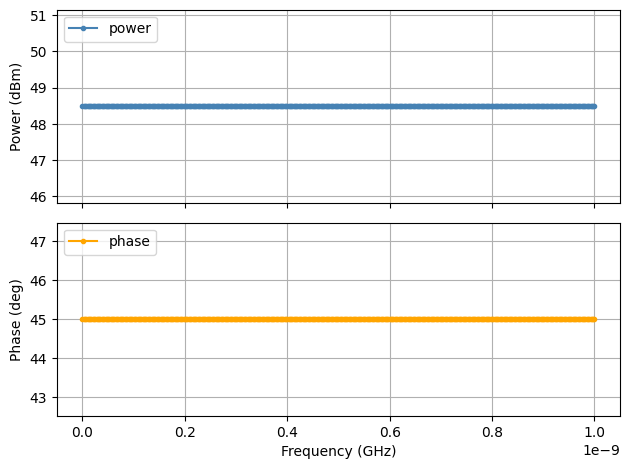

In [12]:
plot_sweeper(amp_sweep_g1, data)

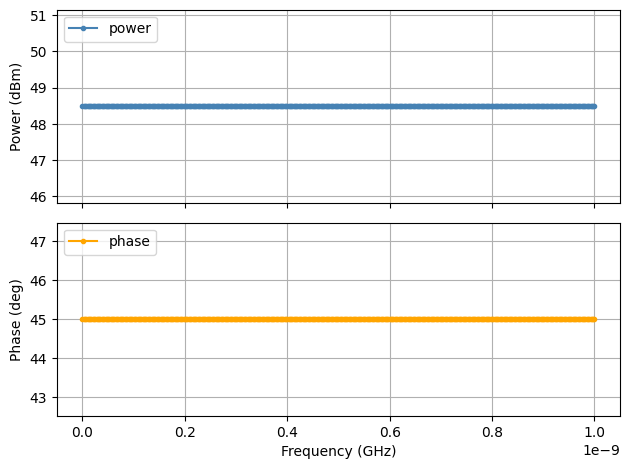

In [13]:
plot_sweeper(amp_sweep_g1, data)

In [ ]:
plot_sweeper(amp_sweep_g1, data)